In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import pickle
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from matplotlib import rcParams
rcParams['grid.color']="0.9"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
df_submission=pd.DataFrame({"QuoteNumber":df_test.QuoteNumber})

In [3]:
import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
def feature_engineering(df):
    df["date"] = pd.to_datetime(df.Original_Quote_Date)
    df['DOW'] = map(lambda x: x.weekday(), df.date)
    df['weekday']= map(lambda x: 0 if x>4 else 1, df.DOW)
    df['month']=map(lambda x: x.month, df.date)
    df['day']=map(lambda x: x.day, df.date)
    df['year']=map(lambda x: x.year, df.date)
    df['week']=map(lambda x: x.isocalendar()[1], df.date)
    

    
    #Include holidays
    cal=calendar()
    holidays=cal.holidays()
    bool_holiday=df['date'].isin(holidays)

    df['Holiday']=map(lambda x: 1 if x==True else 0, bool_holiday)
    
    #Fill missing values
    df.fillna(-1,inplace=True)
    df["NAs"] = np.sum(df<0, axis = 1)

    cols = [col for col in df.columns if col != "QuoteConversion_Flag"]
    df["Zeros"]=np.sum(df[cols] == 0, axis = 1)
    
    df= df.drop_duplicates()
    df = df.drop('Original_Quote_Date', axis=1)
    df = df.drop("QuoteNumber", axis=1)
    df = df.drop('PropertyField6', axis=1)
    df = df.drop('GeographicField10A', axis=1)
    
    #df = df.drop('date', axis=1)
    
    return df

In [4]:
def standardize(df, features):
    from sklearn.preprocessing import StandardScaler
    sc=StandardScaler(with_std=True)
    df[features]=sc.fit_transform(df[features].values)
    return df

In [6]:
def remove_low_var(df, df_test, features, threshold=0.01):
    variances={}
    
    for col in features:

        variances[col]=df[col].var()
        if (variances[col]<=threshold):
            df.drop(col, axis=1)
            df_test.drop(col, axis=1)
    
    return df, df_test

#     import operator
#     sorted_variances = sorted(variances.items(), key=operator.itemgetter(1))
#     sorted_variances

In [7]:
from sklearn import preprocessing
def encode_labels(df_train, df_test):
    
    for col in df_train.columns:
        if df_train[col].dtype=='object':
            encode = preprocessing.LabelEncoder()
            encode.fit(list(df_train[col].values) + list(df_test[col].values))
            df_train[col] = encode.transform(list(df_train[col].values))
            df_test[col] = encode.transform(list(df_test[col].values))
    return df_train, df_test

In [8]:
df=feature_engineering(df)
df_test=feature_engineering(df_test)

## EXPLORATORY DATA ANALYSIS

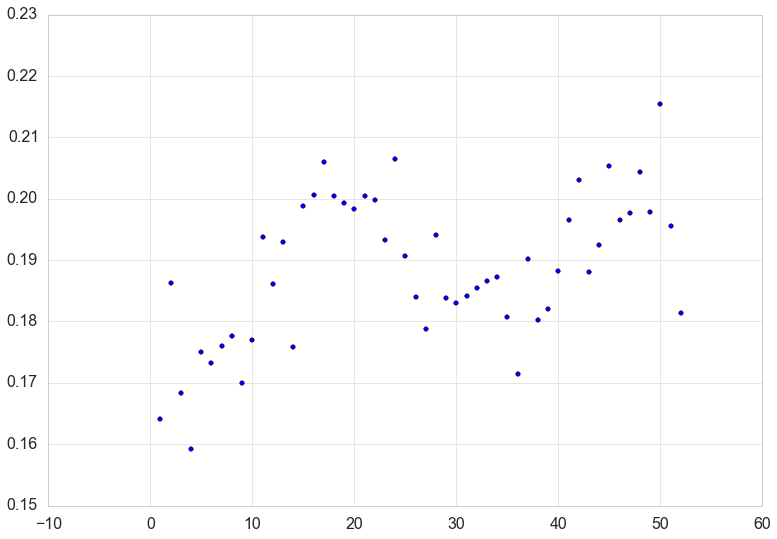

In [33]:
test=df.groupby(by='week').mean().QuoteConversion_Flag
plt.scatter(test.index, test.values)

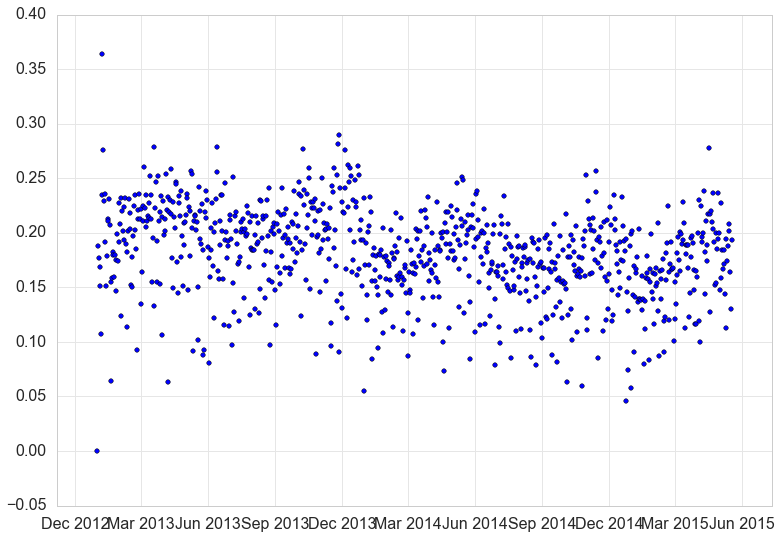

In [31]:
test=df.groupby(by='date').mean().QuoteConversion_Flag
plt.scatter(test.index, test.values)

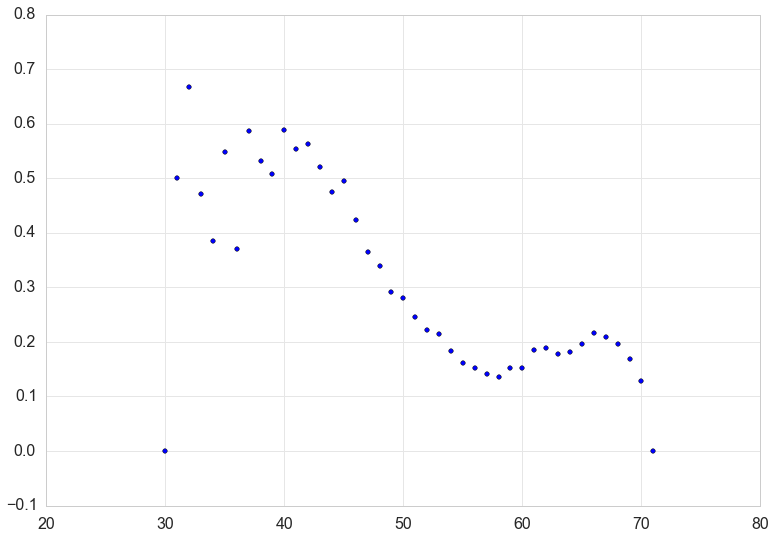

In [23]:
test=df.groupby(by='Zeros').mean().QuoteConversion_Flag
plt.scatter(test.index, test.values)

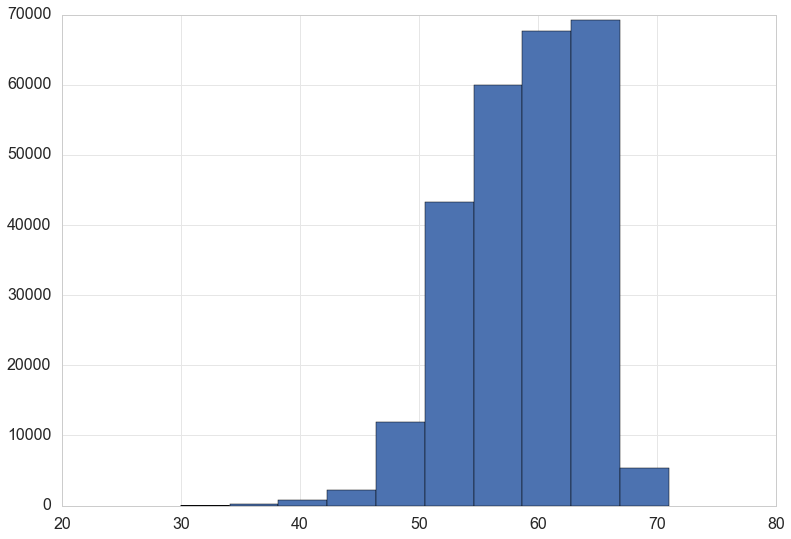

In [25]:
plt.hist(df.Zeros);

In [9]:
features=list(df.columns)
features.remove("QuoteConversion_Flag")
features.remove("date")

In [43]:
df.dtypes

QuoteConversion_Flag      int64
Field6                   object
Field7                    int64
Field8                  float64
Field9                  float64
Field10                  object
Field11                 float64
Field12                  object
CoverageField1A           int64
CoverageField1B           int64
CoverageField2A           int64
CoverageField2B           int64
CoverageField3A           int64
CoverageField3B           int64
CoverageField4A           int64
CoverageField4B           int64
CoverageField5A           int64
CoverageField5B           int64
CoverageField6A           int64
CoverageField6B           int64
CoverageField8           object
CoverageField9           object
CoverageField11A          int64
CoverageField11B          int64
SalesField1A              int64
SalesField1B              int64
SalesField2A              int64
SalesField2B              int64
SalesField3               int64
SalesField4               int64
                         ...   
Geograph

In [94]:
df.QuoteConversion_Flag.mean()

0.1875107860695754

In [10]:
df, df_test = encode_labels(df, df_test)

## SKLEARN GRADIENT BOOST IMPLEMENTATION

In [36]:
"""
Function
--------
create_mask

Inputs
------
indices : list of indices to make up mask
size : int length of resulting mask
   
Returns
-------
mask : boolean mask (list) for indices specified
"""
def create_mask(indices, size):
    mask=np.zeros(size, dtype='int')
    mask[indices]=1
    mask = (mask==1)
    return mask

In [37]:
from sklearn.cross_validation import train_test_split
#make lists of indices to be used for training and test (and validation) sets
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7, random_state=50)
#create training mask
tr_mask=create_mask(itrain, df.shape[0])

#split test into test and validation
test_and_val=~tr_mask
testvalSeries=pd.Series(data=~tr_mask)
test_val=testvalSeries[testvalSeries==True]

#sample 33 percent of test indices to be used for validation set
ival=test_val.sample(frac=0.33, replace=False, random_state=50).index
te_mask=test_and_val

#remove validation indices from test mask
te_mask[ival]=False

#create final validation mask
val_mask=create_mask(ival, df.shape[0])

#verify proportions of data between training, test and validation sets
np.mean(tr_mask), np.mean(val_mask), np.mean(te_mask)

(0.69999961649530396, 0.099001737276272941, 0.20099864622842306)

In [38]:
'''
Function
--------
bal_subs_data

Inputs
------
Xtrain : a samples-features training data matrix in the scikit-learn style
ytrain: the response vector of 1s and 0s for traning set
subsample : number of samples per class (creates balanced split) in subsample for training
   
Returns
-------
Subsampled and balanced training matrices.
'''
def bal_subs_data(Xtrain, ytrain, subsample):
    #based on code from hw 3
    jtrain=np.arange(0, ytrain.shape[0])
    n_pos=len(jtrain[ytrain==1])
    n_neg=len(jtrain[ytrain==0])
    np.random.seed(50)
    ineg = np.random.choice(jtrain[ytrain==0], subsample, replace=False)
    ipos = np.random.choice(jtrain[ytrain==1], subsample, replace=False)
    alli=np.concatenate((ipos, ineg))
    return Xtrain[alli], ytrain[alli]

In [39]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: dictionary with key=parameter names and value=list of parameter values
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s
n_folds: the number of cross-validation folds (default 5)
score_func: Scoring function to be used in cross validation ie. "log-loss"
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
Based on code from CS109 homework 3 2015. Performs cross validation
"""
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
def cv_optimize(clf, params,  X, y, n_jobs=1, n_iter=10, n_folds=5, score_func=None, random_cv=False):
    #enable use of custom scoring system
    if not random_cv:
        if score_func:
            cv = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
        else:
            cv = GridSearchCV(clf, param_grid=params, n_jobs=n_jobs, cv=n_folds)
    else:
        if score_func:
            cv = RandomizedSearchCV(clf, param_distributions=params, n_iter=n_iter, scoring=score_func, 
                                    n_jobs=n_jobs, cv=n_folds, random_state=50)
        else:
            cv = RandomizedSearchCV(clf, param_distributions=params, n_iter=n_iter, 
                                    n_jobs=n_jobs, cv=n_folds, random_state=50)
        print 'RANDOMIZED SEARCH'
            
    cv.fit(X, y)
    print "BEST", cv.best_params_, cv.best_score_, cv.grid_scores_
    best = cv.best_estimator_
    return best

In [40]:
"""
Function
--------
do_classify

Inputs
------
clf : instance of scikit learn classifier
params : dictionary with key=parameter names and value=list of parameter values 
indf : Dataframe with training and test data
featurenames : list of features to be used in X matrix
targetname : string name of reponse variable column
tr_mask : Boolean training mask (list)
te_mask : Boolean test mask (list)
score_func : Scoring function to be used in cross validation ie. "log-loss"
n_folds : number of cross validation folds
n_jobs=1 : number of jobs for parallel processing
random_cv : Boolean describing if random (not grid) cross validation will be used
n_iter=10 : number of iterations for random cross validation
subsample : number of samples per class (creates balanced split) in subsample for training
   
Returns
-------
clf : fit instance of scikit learn classifier
probs : list of predicted probabilities on test set
ytest : actual response values from test set
     
Notes
-----
Based on code from CS109 homework 3. Performs classification process.
"""
from sklearn.metrics import roc_auc_score
def do_classify(clf, params, indf, featurenames, targetname, tr_mask, te_mask,
                score_func=None, n_folds=5, n_jobs=1, random_cv=False, n_iter=10, 
                subsample=False):
    #create train and test matrices from test and training masks
    Xtrain=indf[featurenames][tr_mask].values
    Xtest=indf[featurenames][te_mask].values
    ytrain=indf[targetname][tr_mask].values
    ytest=indf[targetname][te_mask].values
    
    if subsample:
        Xtrain, ytrain = bal_subs_data(Xtrain, ytrain, subsample)
    if params:
        #if parameters for cross validation are provided, perform cross validation
        clf = cv_optimize(clf, params, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, 
                          random_cv=random_cv, score_func=score_func, n_iter=n_iter)
    #train model with best parameters from cross validation
    clf=clf.fit(Xtrain, ytrain)
     
    #predict class probabilities from fit model and return log-loss value of predictions
    probs=clf.predict_proba(Xtest)[:, 1]
    score=roc_auc_score(ytest, probs)
    print "FINAL AUC: %0.4f" %(score)
    return clf, probs, ytest

## XGBOOST NO CV

In [14]:
import xgboost as xgb
dtrain = xgb.DMatrix(df[features], df['QuoteConversion_Flag']) 
dtest = xgb.DMatrix(df_test[features])


param =     {
    #1- General Parameters       
    'booster' : "gbtree", #booster [default=gbtree]
    'silent': 0 , #silent [default=0]
    #'nthread' : -1 , #nthread [default to maximum number of threads available if not set]

    #2A-Parameters for Tree Booster   
    'eta'  :0.023, # eta [default=0.3] range: [0,1]
    #'gamma':0 ,#gamma [default=0] range: [0,âˆž]
    'max_depth'           :6, #max_depth [default=6] range: [1,âˆž]
    #'min_child_weight':1,  #default=1]range: [0,âˆž]
    #'max_delta_step':0, #max_delta_step [default=0] range: [0,âˆž]
    'subsample'           :0.83, #subsample [default=1]range: (0,1]
    'colsample_bytree'    :0.77, #colsample_bytree [default=1]range: (0,1]
    #'lambda': 1,  #lambda [default=1]
    #'alpha':0.0001, #alpha [default=0]
    
    
    #2B- Parameters for Linear Booster
    #'lambda': 0,  #lambda [default=0]
    #'alpha':0, #alpha [default=0]
    #'lambda_bias':0, #default 0
    
    #3- earning Task Parameters
    'objective': 'binary:logistic',  #objective [ default=reg:linear ]
    #'base_score'=0.5,        #base_score [ default=0.5 ]
    'eval_metric' : 'auc', #eval_metric [ default according to objective ]
    'seed':500 #seed [ default=0 ]
  
    }

num_boost_round = 1800

bst = xgb.train(
    params=param, 
    dtrain=dtrain,
    num_boost_round=num_boost_round
    #early_stopping_rounds=15
    #watchlist
    )

        
#prediction
preds= bst.predict(dtest)

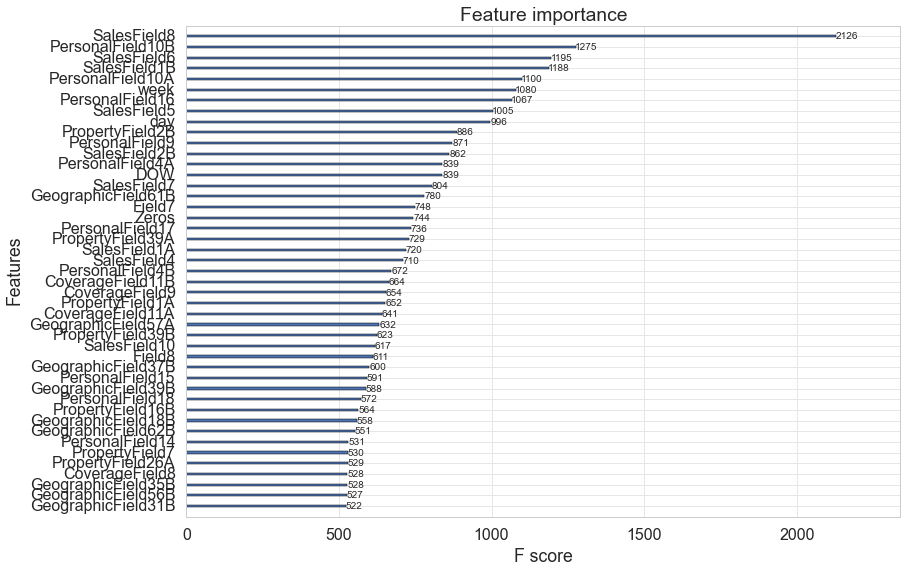

In [63]:
import operator
importances=bst.get_fscore()
sorted_imp = sorted(importances.items(), key=operator.itemgetter(1))
xgb.plot_importance(dict(sorted_imp[-45:]))


In [48]:
paramcv =     {
    #1- General Parameters       
    'booster' : "gbtree", #booster [default=gbtree]
    'silent': 0 , #silent [default=0]
    #'nthread' : -1 , #nthread [default to maximum number of threads available if not set]

    #2A-Parameters for Tree Booster   
    'eta'  :0.01, # eta [default=0.3] range: [0,1]
    #'gamma':0 ,#gamma [default=0] range: [0,âˆž]
    'max_depth'           :7, #max_depth [default=6] range: [1,âˆž]
    'min_child_weight':3,  #default=1]range: [0,âˆž]
    #'max_delta_step':0, #max_delta_step [default=0] range: [0,âˆž]
    'subsample'           :0.85, #subsample [default=1]range: (0,1]
    'colsample_bytree'    :0.66, #colsample_bytree [default=1]range: (0,1]
    #'lambda': 1,  #lambda [default=1]
    #'alpha':0.0001, #alpha [default=0]
    
    
    #2B- Parameters for Linear Booster
    #'lambda': 0,  #lambda [default=0]
    #'alpha':0, #alpha [default=0]
    #'lambda_bias':0, #default 0
    
    #3- earning Task Parameters
    'objective': 'binary:logistic',  #objective [ default=reg:linear ]
    #'base_score'=0.5,        #base_score [ default=0.5 ]
    'eval_metric' : 'auc', #eval_metric [ default according to objective ]
    'seed':500 #seed [ default=0 ]
  
    }

test=xgb.cv(paramcv, dtrain, 25, nfold=5, metrics={'auc'}, seed = 0)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.915079,0.021495,0.916038,0.021060
1,0.934138,0.012856,0.934844,0.012635
2,0.938615,0.010009,0.939327,0.009773
3,0.942018,0.008535,0.942894,0.008441
4,0.943399,0.008695,0.944212,0.008738
5,0.946979,0.003669,0.947731,0.003638
6,0.948436,0.002517,0.949184,0.002073
7,0.948105,0.002850,0.948782,0.002605
8,0.949119,0.001797,0.949839,0.001521
9,0.949524,0.001937,0.950204,0.001394


In [49]:
paramcv =     {
    #1- General Parameters       
    'booster' : "gbtree", #booster [default=gbtree]
    'silent': 0 , #silent [default=0]
    #'nthread' : -1 , #nthread [default to maximum number of threads available if not set]

    #2A-Parameters for Tree Booster   
    'eta'  :0.01, # eta [default=0.3] range: [0,1]
    #'gamma':0 ,#gamma [default=0] range: [0,âˆž]
    'max_depth'           :7, #max_depth [default=6] range: [1,âˆž]
    'min_child_weight':1,  #default=1]range: [0,âˆž]
    #'max_delta_step':0, #max_delta_step [default=0] range: [0,âˆž]
    'subsample'           :0.83, #subsample [default=1]range: (0,1]
    'colsample_bytree'    :0.77, #colsample_bytree [default=1]range: (0,1]
    #'lambda': 1,  #lambda [default=1]
    #'alpha':0.0001, #alpha [default=0]
    
    
    #2B- Parameters for Linear Booster
    #'lambda': 0,  #lambda [default=0]
    #'alpha':0, #alpha [default=0]
    #'lambda_bias':0, #default 0
    
    #3- earning Task Parameters
    'objective': 'binary:logistic',  #objective [ default=reg:linear ]
    #'base_score'=0.5,        #base_score [ default=0.5 ]
    'eval_metric' : 'auc', #eval_metric [ default according to objective ]
    'seed':500 #seed [ default=0 ]
  
    }

xgb.cv(paramcv, dtrain, 25, nfold=5, metrics={'auc'}, seed = 0)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.918314,0.025211,0.919640,0.024016
1,0.939328,0.011077,0.940145,0.010309
2,0.945023,0.002692,0.945785,0.002045
3,0.946931,0.003515,0.947688,0.003430
4,0.947225,0.004337,0.947996,0.004517
5,0.948717,0.002339,0.949444,0.002482
6,0.949286,0.001450,0.950011,0.001589
7,0.949207,0.001935,0.949940,0.002201
8,0.949644,0.001520,0.950346,0.001635
9,0.949910,0.001585,0.950532,0.001462


In [50]:
paramcv =     {
    #1- General Parameters       
    'booster' : "gbtree", #booster [default=gbtree]
    'silent': 0 , #silent [default=0]
    #'nthread' : -1 , #nthread [default to maximum number of threads available if not set]

    #2A-Parameters for Tree Booster   
    'eta'  :0.02, # eta [default=0.3] range: [0,1]
    #'gamma':0 ,#gamma [default=0] range: [0,âˆž]
    'max_depth'           :10, #max_depth [default=6] range: [1,âˆž]
    'min_child_weight':1,  #default=1]range: [0,âˆž]
    #'max_delta_step':0, #max_delta_step [default=0] range: [0,âˆž]
    'subsample'           :0.85, #subsample [default=1]range: (0,1]
    'colsample_bytree'    :0.66, #colsample_bytree [default=1]range: (0,1]
    #'lambda': 1,  #lambda [default=1]
    #'alpha':0.0001, #alpha [default=0]
    
    
    #2B- Parameters for Linear Booster
    #'lambda': 0,  #lambda [default=0]
    #'alpha':0, #alpha [default=0]
    #'lambda_bias':0, #default 0
    
    #3- earning Task Parameters
    'objective': 'binary:logistic',  #objective [ default=reg:linear ]
    #'base_score'=0.5,        #base_score [ default=0.5 ]
    'eval_metric' : 'auc', #eval_metric [ default according to objective ]
    'seed':500 #seed [ default=0 ]
  
    }

xgb.cv(paramcv, dtrain, 30, nfold=5, metrics={'auc'}, seed = 0)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.929613,0.021880,0.933443,0.019930
1,0.942688,0.012117,0.946034,0.011438
2,0.947581,0.008574,0.950734,0.007964
3,0.950154,0.007262,0.953332,0.006989
4,0.950694,0.007426,0.954005,0.006887
5,0.953756,0.003234,0.956835,0.002977
6,0.954815,0.001847,0.957980,0.001460
7,0.954588,0.002445,0.957722,0.002043
8,0.955514,0.001332,0.958598,0.000995
9,0.955875,0.001485,0.958997,0.000848


In [18]:
df_submission=df_submission.set_index("QuoteNumber")
df_submission['QuoteConversion_Flag']=preds
df_submission.to_csv('submission4.csv')

In [19]:
df_submission.head()

,QuoteConversion_Flag
QuoteNumber,
3,0.000511
5,0.029428
7,0.019792
9,0.005585
10,0.313402


## XGBOOST SKLEARN CROSS VALIDATION

In [54]:
import xgboost as xgb

parameters = {"max_depth": [3, 5, 10, 15],
              'colsample_bytree':[0.5,0.8,1],
              'subsample':[0.5,0.8,1],
              "n_estimators": [75, 100, 125]}

clf_XGBT = xgb.XGBClassifier(nthread=-1,
                            learning_rate=0.025,
                            silent=0)

clf_XGBT, probs_XGBT, ytest= do_classify(clf_XGBT, parameters, df, features, 'QuoteConversion_Flag', tr_mask, 
                                         te_mask, score_func='roc_auc', n_folds=5, n_jobs=1, 
                                         random_cv=True, n_iter=10, subsample=3000)

#xgb_model = clf.fit(train, y)

RANDOMIZED SEARCH
BEST {'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 1, 'max_depth': 10} 0.952707222222 [mean: 0.94961, std: 0.00572, params: {'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.8, 'max_depth': 5}, mean: 0.95245, std: 0.00414, params: {'n_estimators': 125, 'subsample': 0.5, 'colsample_bytree': 1, 'max_depth': 10}, mean: 0.94681, std: 0.00608, params: {'n_estimators': 75, 'subsample': 1, 'colsample_bytree': 0.5, 'max_depth': 5}, mean: 0.94864, std: 0.00445, params: {'n_estimators': 125, 'subsample': 0.5, 'colsample_bytree': 0.5, 'max_depth': 15}, mean: 0.95271, std: 0.00448, params: {'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 1, 'max_depth': 10}, mean: 0.94166, std: 0.00817, params: {'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.5, 'max_depth': 3}, mean: 0.95191, std: 0.00403, params: {'n_estimators': 125, 'subsample': 0.8, 'colsample_bytree': 0.8, 'max_depth': 15}, mean: 0.94790, std: 0.00533, params: {'n_estimators

In [56]:
clf_XGBT_new = xgb.XGBClassifier(nthread=-1, learning_rate=0.025, silent=0, 
                                 n_estimators= 100, subsample= 0.8, colsample_bytree= 1, max_depth= 10)

clf_XGBT_new, probs_XGBT_new, ytest= do_classify(clf_XGBT_new, False, df, features, 'QuoteConversion_Flag', tr_mask, 
                                                 te_mask, score_func='roc_auc', n_folds=5, n_jobs=1, 
                                                 random_cv=True, n_iter=10)


FINAL AUC: 0.9619


## SKLEARN GRADIENT BOOST IMPLEMENTATION CV

In [ ]:
from scipy.stats import randint
from sklearn.ensemble import GradientBoostingClassifier
np.random.RandomState(seed=50)
parameters = {"max_depth": [1, 5, 10, 20],
              "max_features": [None],
              "min_samples_split": randint(1, 11),
              "min_samples_leaf": randint(1, 11),
              "n_estimators": [100]}

# parameters = {"max_depth": [10],
#               "max_features": [200],
#               "min_samples_split": [5],
#               "min_samples_leaf": [5],
#               "n_estimators": [25]}

clf_GBT = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, random_state=50)
clf_GBT, probs_GBT, ytest= do_classify(clf_GBT, parameters, df, features, 'QuoteConversion_Flag', tr_mask, 
                                       te_mask, score_func='roc_auc', n_folds=5, n_jobs=1, 
                                       random_cv=True, n_iter=5)

## MODEL CALIBRATION

In [20]:
"""
Function
--------
calibration_plot

Inputs
------
probs : array of predicted probabilities
ytest : array of observed binary responses
   
Returns
-------
N/A
     
Notes
-----
Creates a plot of classifier calibration
Adapted from code from CS109 hw 5
"""
def calibration_plot(prob, ytest):
    data = pd.DataFrame(dict(prob=prob, outcome=ytest))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(+)")
    
    #the distribution of P(+)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(+)")
    plt.ylabel("Number")

In [47]:
"""
Function
--------
do_calibration

Inputs
------
clf : scikit learn classifier instance 
X_cal_tr : array for features data used in fitting calibration
y_cal_tr : array for response variable used in fitting calibration
x_cal_test : array of features data to be used to predict probabilities
cv : number of cross validation folds for calibration
method : method of classifier calbration (default : 'isotonic')
   
Returns
-------
clf : new calibrated classifier instance
prob_pos_calibrated : array of calibrated probabilities of positive response
"""
from sklearn.calibration import CalibratedClassifierCV
def do_calibration(clf, df, features, response, te_mask, cv=5, method='isotonic'):
    #instantiate calibrator
    clf = CalibratedClassifierCV(clf, cv=cv, method=method)
    
    X=df[features][te_mask].values
    y=df[response][te_mask].values
    #fit calibrator to validation data
    clf.fit(X, y)
    
    #predict calibrated posterior probabilities
    
    return clf

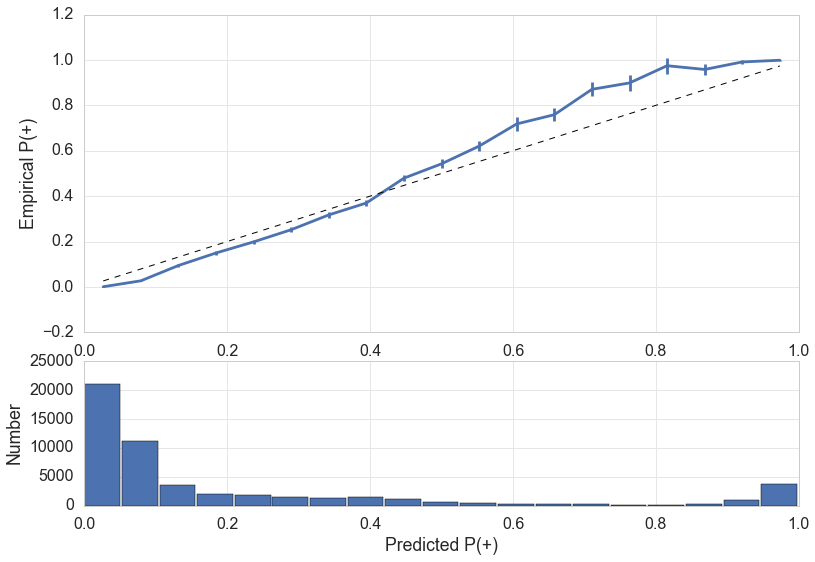

In [57]:
calibration_plot(probs_XGBT_new, ytest)

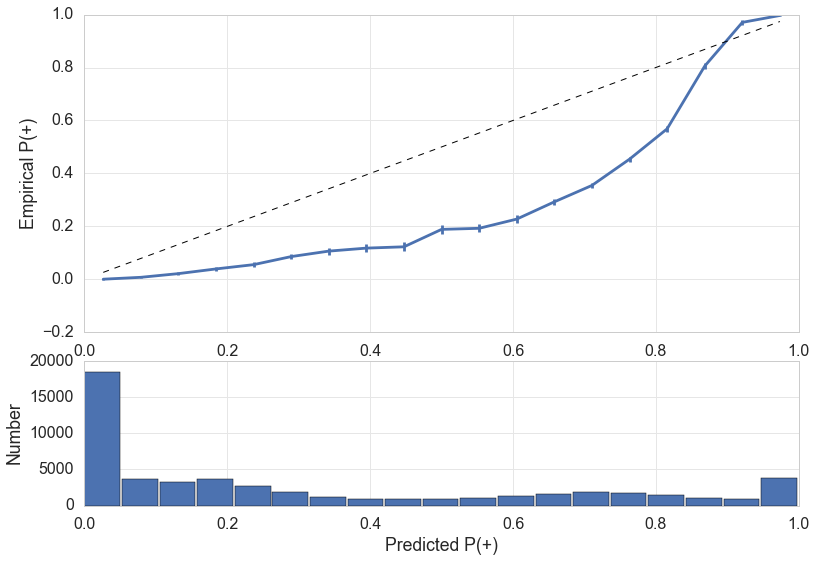

In [55]:
calibration_plot(probs_XGBT, ytest)

In [58]:
#perform isotonic calibration on the GBT
clf_XGBT_cal_new=do_calibration(clf_XGBT_new, df, features, 'QuoteConversion_Flag', te_mask)

#prob_pos_calibrated = clf.predict_proba(df_test.values)[:, 1]


In [59]:
prob_pos_calibrated = clf_XGBT_cal_new.predict_proba(df_test[features].values)[:, 1]

## FINAL SUBMITTAL

In [61]:
#df_submission=df_submission.set_index("QuoteNumber")
df_submission['QuoteConversion_Flag']=prob_pos_calibrated
#df_submission.to_csv('submission.csv')

In [63]:
df_submission.to_csv('submission3.csv')

## ENSEMBLE

In [22]:
df1=pd.read_csv("submission.csv")
df2=pd.read_csv("submission2.csv")
df3=pd.read_csv("submission3.csv")
df4=pd.read_csv("submission4.csv")

In [25]:
df1['SUB2']=df2.QuoteConversion_Flag

In [27]:
df1['SUB3']=df3.QuoteConversion_Flag
df1['SUB4']=df4.QuoteConversion_Flag

In [28]:
df1.head()

,QuoteNumber,QuoteConversion_Flag,SUB2,SUB3,SUB4
0,3,0.000000,0.000000,0.000258,0.000511
1,5,0.046625,0.053849,0.042894,0.029428
2,7,0.037931,0.013569,0.022323,0.019792
3,9,0.007472,0.005669,0.005115,0.005585
4,10,0.232485,0.165277,0.221547,0.313402


In [31]:
df1=df1.set_index("QuoteNumber")
test=df1.mean(axis=1)

In [38]:
final=pd.DataFrame(test, columns=['QuoteConversion_Flag'])

In [39]:
final.to_csv('ensemble1.csv')